# Import Library

In [1]:
from IPython.display import display
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import string
import math
import warnings
warnings.filterwarnings("ignore")

## Set parameters

In [2]:
# Number of recommended resources
N_LIST =  [5,15,25,35,45,55,65,75,85,95,]
# Number of similar learners
M = 40
# Number of clusters
K = 4
# The length of learning behavior patterns
LBP_LEN = 1
# Whether to use clustering
USE_CLUSTER = True
# Whether to use TF-IDF values as feature values
USE_TF_IDF = True
# Student course selection information
USE_MODULE_INFO = False
# Set this parameter to select the type of recommended learning resources. Here, we select all types of learning resources
R_TYPE = [
    'forumng', 'oucontent', 'subpage', 'homepage', 'quiz', 
          'resource','url', 
    'ouwiki', 'oucollaborate', 'page', 'questionnaire',
       'externalquiz', 'ouelluminate', 'glossary', 'dataplus', 'dualpane',
       'htmlactivity', 'folder', 
        'sharedsubpage', 'repeatactivity'
         ]

# Load Dataset

In [3]:
studentVle = pd.read_csv('data/OULAD_Dataset/studentVle.csv')
studentAssessment = pd.read_csv('data/OULAD_Dataset/studentAssessment.csv')
vle = pd.read_csv('data/OULAD_Dataset/vle.csv')

## View Data

In [4]:
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [5]:
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [6]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


## Screening Students

In [7]:
min_score = 60
def get_need_stu():
    """Students with an average score of 60 or higher"""
    stu_score_mean = studentAssessment.groupby('id_student').mean()['score']
    need_stu = stu_score_mean[stu_score_mean>=min_score]
    stu_vle = studentVle['id_student'].value_counts()
    stu_vle = stu_vle[stu_vle>LBP_LEN]
    need_stu_have = []
    for one in need_stu.index:
        if one in stu_vle.index:
            need_stu_have.append(one)
    print(f'Number of learners：',len(need_stu_have))
    return need_stu_have
need_stu_have = get_need_stu()
all_stu_len = len(need_stu_have)

Number of learners： 19294


## Generate Basic Data

In [8]:
def generate_uppercase_sequence(length):
    """Obtain uppercase ABC of corresponding length"""
    uppercase_letters = string.ascii_uppercase
    sequence = []
    for i in range(length):
        sequence.append(uppercase_letters[i % 26])
    return sequence

def get_seq(one_seq):
    """Convert a string to its original sequence"""
    one_real_seq = []
    for one in one_seq:
        one_real_seq.append(event_code_A[one])
    return one_real_seq

In [9]:
# Mapping of Activity Types and Learning Resources
stie_2_type = dict(zip(vle['id_site'],vle['activity_type']))
studentVle = studentVle[studentVle['id_student'].isin(need_stu_have)].reset_index(drop=True)
studentVle['activity_type'] = studentVle['id_site'].map(stie_2_type)
studentVle.index = list(studentVle['id_student'])
all_act_type = list(studentVle['activity_type'].value_counts().index)
event_code = dict(zip(all_act_type,generate_uppercase_sequence(len(all_act_type))))
event_code_A = dict(zip(generate_uppercase_sequence(len(all_act_type)),all_act_type))
studentVle['event_code'] = studentVle['activity_type'].map(event_code)
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,event_code
28400,AAA,2013J,28400,546652,-10,4,forumng,A
28400,AAA,2013J,28400,546652,-10,1,forumng,A
28400,AAA,2013J,28400,546652,-10,1,forumng,A
28400,AAA,2013J,28400,546614,-10,11,homepage,D
28400,AAA,2013J,28400,546714,-10,1,oucontent,B


# Generate learner feature matrix

## Obtain student course selection information

In [10]:
student_module = studentVle[['code_module','code_presentation','id_student']].drop_duplicates()
# Using one hot encoding for representation
studentInfo_one_hot = pd.get_dummies(student_module,columns=['code_module','code_presentation'])
studentInfo_one_hot = studentInfo_one_hot.groupby('id_student').sum()
studentInfo_one_hot.index = list(studentInfo_one_hot.index)
studentInfo_one_hot.to_pickle('data/process_data/studentInfo_one_hot.pkl')

In [11]:
# index is student id
studentInfo_one_hot = pd.read_pickle('data/process_data/studentInfo_one_hot.pkl')
studentInfo_one_hot.head()

,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,code_presentation_2013B,code_presentation_2013J,code_presentation_2014B,code_presentation_2014J
6516,1,0,0,0,0,0,0,0,0,0,1
8462,0,0,0,2,0,0,0,0,1,0,1
11391,1,0,0,0,0,0,0,0,1,0,0
23629,0,1,0,0,0,0,0,1,0,0,0
23698,0,0,1,0,0,0,0,0,0,0,1


## Extracting learner behavior sequences

In [12]:
# # This will run for about 5 minutes, so we have saved the process data
# # The sequence of learning behaviors for each student
# all_seq_data = {}
# # Learning resources for each student
# stu_resource = {}
# for one_stu in tqdm(need_stu_have):
#     one_stu_data = studentVle.loc[one_stu].copy()
#     one_stu_res = dict(one_stu_data[one_stu_data['activity_type'].isin(R_TYPE)].groupby('id_site').sum()['sum_click'])
#     if len(one_stu_res.keys())==0:
#         continue
#     stu_resource[one_stu] = one_stu_res
#     all_seq_data[one_stu] = list(one_stu_data['event_code'])
# pd.to_pickle(stu_resource,'data/process_data/stu_resource.plk')
# pd.to_pickle(all_seq_data,'data/process_data/all_seq_data.plk')

In [13]:
stu_resource = pd.read_pickle('data/process_data/stu_resource.plk')
all_seq_data = pd.read_pickle('data/process_data/all_seq_data.plk')

## Extracting Learning Behavior Patterns

In [14]:
def sort_dict(one_dict,reverse=True):
    return dict(sorted(one_dict.items(), key=lambda x: x[1],reverse=True))

def get_dup_seq(one_seq,k):
    """
    Get Learning Behavior Patterns
    """
    one_dup_seq = {}
    for i in range(len(one_seq) - k + 1):
        subseq = one_seq[i:i+k]
        if subseq in one_dup_seq:
            one_dup_seq[subseq] += 1
        else:
            one_dup_seq[subseq] = 1
    one_dup_seq = sort_dict(one_dup_seq)
    return one_dup_seq

In [15]:
all_stu_seq = {}
all_seq_num = {}
for one_stu,one_seq in tqdm(all_seq_data.items()):
    all_stu_seq[one_stu] = {}
    one_dup_seq = get_dup_seq(''.join(one_seq),LBP_LEN)
    all_stu_seq[one_stu] = one_dup_seq
    for one_sub_key in one_dup_seq.keys():
        if one_sub_key in all_seq_num:
            all_seq_num[one_sub_key] += 1
        else:
            all_seq_num[one_sub_key] = 1

100%|██████████| 19294/19294 [00:01<00:00, 10335.22it/s]


## Calculate TF-IDF value

In [16]:
all_stu_num = len(all_seq_data.keys())
seq_IDF = [math.log(all_stu_num/(one+1),10) for one in list(all_seq_num.values())]
all_seq_IDF = dict(zip(list(all_seq_num.keys()),seq_IDF))
stu_TF_IDF = {}
for key,sub_seq in tqdm(all_stu_seq.items()):
    one_stu_TF_IDF = {}
    seq_all_num = sum(list(sub_seq.values()))
    for sub_k,sub_v in sub_seq.items():
        if sub_k not in all_seq_IDF:
            continue
        one_TF = sub_v/seq_all_num
        one_stu_TF_IDF[sub_k] = all_seq_IDF[sub_k]*one_TF
    stu_TF_IDF[key] = one_stu_TF_IDF

100%|██████████| 19294/19294 [00:00<00:00, 249103.17it/s]


In [17]:
need_feature = dict(zip(list(all_seq_num.keys()),[0]*len(all_seq_num)))
all_feature_values = []
for one_stu,one_TF_IDF in tqdm(stu_TF_IDF.items()):
    one_need_feature = need_feature.copy()
    if USE_TF_IDF:
        one_need_feature.update(one_TF_IDF)
    else:
        one_need_feature.update(all_stu_seq[one_stu])
    all_feature_values.append(one_need_feature)
stu_id_index = list(stu_TF_IDF.keys())
my_data = pd.DataFrame(all_feature_values,index=stu_id_index)
my_data.head()

100%|██████████| 19294/19294 [00:00<00:00, 748424.55it/s]


,B,A,D,C,G,F,O,L,I,H,E,J,N,M,K,P,R,Q,S,T
6516,0.005694,0.004769,0.000011,0.000236,0.004593,0.000151,0.005261,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8462,0.001752,0.001246,0.000008,0.000804,0.003470,0.000881,0.000000,0.023479,0.009561,0.005729,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11391,0.008153,0.004786,0.000009,0.000120,0.001266,0.000295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23629,0.000000,0.007338,0.000012,0.000073,0.000000,0.000178,0.000000,0.000000,0.000000,0.000000,0.024948,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23698,0.000269,0.002484,0.000010,0.000478,0.001017,0.000689,0.000000,0.000000,0.000000,0.000000,0.024451,0.001453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load student course selection information

In [18]:
if USE_MODULE_INFO:
    my_data = pd.concat([my_data,studentInfo_one_hot.loc[stu_id_index]],join='inner',axis=1)
    my_data.head()

# Learner clustering

## Finding the appropriate number of clusters

100%|██████████| 28/28 [01:56<00:00,  4.16s/it]


,num,SC,CH
0,2,0.416660,6777.003154
1,3,0.361161,7692.863003
2,4,0.405669,9091.057259
3,5,0.358252,8605.301239
4,6,0.318944,8673.441748
5,7,0.357255,9123.368949
6,8,0.361842,9356.938267
7,9,0.365029,9376.830895
8,10,0.342059,9410.599543
9,11,0.349885,9343.431687


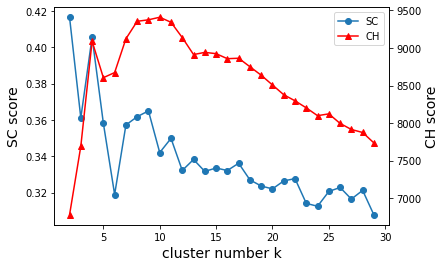

In [19]:
cluster_num = list(range(2,30))
pca = PCA(n_components=5,random_state=2023)
X = pca.fit_transform(my_data.values)
all_result = []
for one in tqdm(cluster_num):
    KM_cluster = KMeans(init='k-means++', n_clusters=one,random_state=2023)
    KM_cluster.fit(X)
    SC = metrics.silhouette_score(X, KM_cluster.labels_, metric='euclidean')# 越大越好
    CH = metrics.calinski_harabasz_score(X, KM_cluster.labels_)# 越大越好
    all_result.append({'num':one,'SC':SC,'CH':CH})
cluster_result = pd.DataFrame(all_result)
display(cluster_result.head(10))
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(cluster_num,cluster_result['SC'],marker='o',label='SC')
ax1.set_xlabel('cluster number k', fontsize=14)
ax1.set_ylabel('SC score', fontsize=14)
ax2 = ax1.twinx()
ax2.plot(cluster_num,cluster_result['CH'].astype('int'), color='r',marker='^',label='CH')
ax2.set_ylabel('CH score', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc=0)
fig.savefig('log/cluster',bbox_inches = 'tight',pad_inches = 0,dpi =350)

## Cluster learners

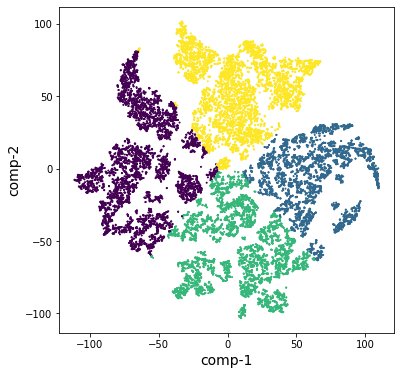

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import manifold
if USE_CLUSTER:
    tsne = manifold.TSNE(n_components=2,learning_rate='auto', init='pca', random_state=42).fit_transform(my_data)
    KM_cluster = KMeans(init='k-means++', n_clusters=K,random_state=2023)
    KM_cluster.fit(tsne)
    all_labels = list(KM_cluster.labels_)
    stu_2_cluster = dict(zip(stu_id_index,all_labels))
    plt.figure(figsize=(6,6))
    plt.scatter(tsne[:,0],tsne[:,1],c=all_labels,s=1,)
    plt.xlabel('comp-1',fontsize=14)
    plt.ylabel('comp-2',fontsize=14)
    plt.savefig('log/tsne',bbox_inches = 'tight',pad_inches = 0,dpi =350)

# Recommendation of learning resources

## Calculate learner similarity

In [21]:
import time
start_time = time.time()
all_stu_pearson = {}
if USE_CLUSTER:
    cluster_data = my_data.copy()
    cluster_data['cluster'] = all_labels
    nee_col = list(cluster_data.columns[:-1])
    for one_cluster in tqdm(range(K)):
        one_clus_data = cluster_data[cluster_data['cluster']==one_cluster][nee_col]
        all_stu_pearson[one_cluster] = one_clus_data.T.corr(method='pearson')
    display(all_stu_pearson[0].head())
else:
    all_stu_pearson =  my_data.T.corr(method='pearson')
    display(all_stu_pearson.head())
end_time = time.time()
run_time = end_time - start_time
print('run time：',run_time)

100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


,8462,24213,25150,27935,29639,29820,33600,33681,33796,33930,...,2689536,2689863,2691780,2692186,2692577,2693243,2694680,2694886,2694933,2695608
8462,1.000000,0.831754,0.126960,0.718416,0.056145,0.063136,-0.088438,0.943153,0.631156,0.859828,...,0.481460,0.870611,0.894602,0.857942,0.849322,0.875672,-0.103507,0.902662,0.735449,0.970067
24213,0.831754,1.000000,0.489475,0.828059,0.420529,0.422894,-0.009325,0.677548,0.453135,0.876060,...,0.405828,0.802102,0.549548,0.814788,0.852140,0.631121,-0.134716,0.904565,0.497587,0.821211
25150,0.126960,0.489475,1.000000,0.708821,0.696266,0.826669,0.211835,0.112556,0.017232,0.555042,...,0.259696,-0.105969,-0.081577,0.453261,0.584925,0.114818,-0.080465,0.453333,0.062593,0.103874
27935,0.718416,0.828059,0.708821,1.000000,0.489475,0.569235,0.087985,0.718345,0.546903,0.934698,...,0.523492,0.487113,0.566845,0.945784,0.915669,0.737533,-0.129714,0.899722,0.551348,0.699334
29639,0.056145,0.420529,0.696266,0.489475,1.000000,0.970675,0.246357,0.002527,0.079315,0.359759,...,0.084628,0.076688,-0.123006,0.330537,0.319328,0.046635,-0.098618,0.324963,-0.049321,0.079032


run time： 5.273155450820923


## Calculate learners' interest in learning resources

In [22]:
all_stu_sim_resource = {}
for one_stu in tqdm(stu_id_index):
    if USE_CLUSTER:
        one_cluster = stu_2_cluster[one_stu]
        k_person = dict(all_stu_pearson[one_cluster].loc[one_stu].sort_values(ascending=False)[:M+1])
    else:
        k_person = dict(all_stu_pearson.loc[one_stu].sort_values(ascending=False)[:M+1])
    k_person[one_stu] = 10
    del k_person[one_stu]
    one_stu_resource = {}
    for sim_stu,sim in k_person.items():
        one_sim_stu_resource = list(stu_resource[sim_stu].keys())
        for one_resource in one_sim_stu_resource:
            if one_resource not in one_stu_resource:
                one_stu_resource[one_resource] = 0
            one_stu_resource[one_resource] += sim
    all_stu_sim_resource[one_stu] = sorted(one_stu_resource.items(), key= lambda k:k[1], reverse=True)

100%|██████████| 19294/19294 [00:43<00:00, 446.00it/s]


## Top N learning resource recommendations

In [23]:
all_re = []
for top_n in tqdm(N_LIST):
    all_stu_rec_video = {}
    for one_stu in stu_id_index:
        all_stu_rec_video[one_stu] = all_stu_sim_resource[one_stu][:top_n]
    all_recall = []
    all_pre = []
    all_f1 = []
    for one_stu in stu_id_index:
        one_train_video = list(stu_resource[one_stu].keys())
        one_hit = 0
        for one in all_stu_rec_video[one_stu]:
            if one[0] in one_train_video:
                one_hit += 1
        one_recall = one_hit/len(one_train_video)
        all_recall.append(one_recall)
        one_pre = one_hit/len(all_stu_rec_video[one_stu])
        all_pre.append(one_pre)
        if (one_recall+one_pre)==0:
            one_f1 = 0
        else:
            one_f1 = (2*one_recall*one_pre)/(one_recall+one_pre)
        all_f1.append(one_f1)
    all_recall_1 = np.mean(all_recall)
    all_pre_1 = np.mean(all_pre)
    all_f1_1 = np.mean(all_f1)
    one_re = {'Top-N':top_n,'Precision':all_pre_1,'Recall':all_recall_1,'F1':all_f1_1,}
    all_re.append(one_re)
all_re_set = pd.DataFrame(all_re)
all_re_set.index = list(all_re_set['Top-N'])
# all_re_set.to_csv(f'log/oulad/K.{K}-LBP.{LBP_LEN}-TF.{USE_TF_IDF}-MODULE.{USE_MODULE_INFO}-CLUSTER.{USE_CLUSTER}.csv',index=False)
all_re_set.head(20)

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


,Top-N,Precision,Recall,F1
5,5,0.644076,0.054274,0.094322
15,15,0.623420,0.149810,0.219929
25,25,0.600862,0.232056,0.300741
35,35,0.579369,0.304183,0.356188
45,45,0.557901,0.367481,0.394581
55,55,0.536460,0.422366,0.420640
65,65,0.515805,0.470779,0.438208
75,75,0.496537,0.514437,0.450214
85,85,0.478618,0.554028,0.458153
95,95,0.461224,0.589182,0.462273


## Visualization of results

Text(0, 0.5, 'Value')

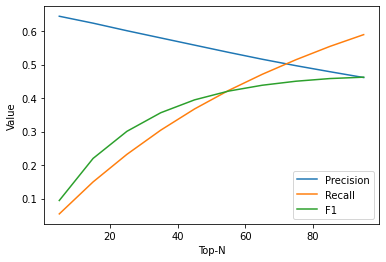

In [24]:
all_re_set_plt = all_re_set[['Precision','Recall','F1']]
one_plot = all_re_set_plt.plot()
one_plot.set_xlabel('Top-N')
one_plot.set_ylabel('Value')